In [1]:
import sys 
from extraction.extract import *
import math
import numpy
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime
from scipy.stats import norm
sys.path.append(".")

GENERAL

Our model right now takes a month of data, trains on the first 20 days of the month and makes predicitons for the rest 11 days. It uses the column "timeslot" as the index and makes a prediction for "departuresDepartureDelay" and "arrivalsArrivalDelay". Right now we use a time interval of 15 minutes and use a lookback of one time slot which is equivalent to 15 minutes.

DATA PREPARATION

Currently with data preparation we have the data being separated and indexed with the timeslot that is a datetime object including year-month-day-time. The idea was a linear model that just uses past data to calculate the labels which are "departuresDepartureDelay" and "arrivalsArrivalDelay". However we ran into the problem of the discontinuity of the data. We only have data for months 3, 6, 9 and 12. So in between the months we have a time interval of 3 months instead of our normal times step of 15 minutes. We had a meeting with Mr. Junzi and he said that instead of having such a continous model we could just make a model that feeds day by day individually. In this case we need to consider the lookback and not include it in the predictions. e.g. if we have a lookback of 3 hours the predictions only start after 03:00 am. 

Some questions we are trying to solve right now is:

    - How do we structure the data such that the model can feed each day individually? The model we considered for this implementation is considering continuous data so we might want to look at other examples and see how they do it
    - How would we have each day only be trained after a cetrain time? Like 03:00 am?

We were also in the process of changing the time step to one hour time intervals. 

The cell below is to remove empty days from the dataset. To be continued

In [15]:
# dataset = generateNNdata("EGLL", timeslotLength=15, catagoricalFlightDuration=False)
# dataset = dataset.set_index("timeslot")
# for i in dataset.index:
#     if (i.year == 2018 and i.month not in [3, 6, 9, 12]) or (i.year == 2019 and i.month not in [3, 6, 9]):
#         dataset.drop(i, axis = 0, inplace = True)

# display(dataset)

What we are doing here is the following:

    - Generate data from the file
    - Drop some columns and rearrange the data such that our labels are the last two columns of the dataset
    - Filter the data to one month of data   
    - Normaliza data  
    - Put our data in the form that LSTM is using to train it. With the function: series_to_supervised

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Generate single airport data and move target labels to the last 2 columns 

dataset = generateNNdata("EGLL", timeslotLength=15, catagoricalFlightDuration=False, start=datetime(2018, 3, 1), end=datetime(2018, 3, 31), forceRegenerateData=True)
dataset = dataset.set_index("timeslot")
display(dataset)

dataset.drop(columns=['departuresArrivalDelay','arrivalsDepartureDelay'])

label1 = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label1)

label2 = dataset.pop('arrivalsArrivalDelay')
dataset.insert(len(dataset.columns), 'arrivalsArrivalDelay', label2)

display(dataset)

# Use a certain number of months/days of Data 

number_of_months = 1
number_of_days = 30
index_slice = number_of_days * 4 * 24
dataset = dataset.iloc[0:index_slice]

# summarize first 5 rows
print(dataset.head(75))

# Normalize values
values = dataset.values
display(values)

# ensure all data is float

values = values.astype('float32')

# normalize features

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning

number_of_past_steps = 12
number_of_future_steps = 2
reframed = series_to_supervised(scaled, n_in=number_of_past_steps, n_out=number_of_future_steps)

# drop columns we don't want to predict

reframed.drop(columns=reframed.columns[[i for i in range(len(reframed.columns)-20, len(reframed.columns)-2)]], inplace=True)
display(reframed)

Generating NN data for EGLL with a timeslot length of 15 minutes


,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,arrivalsArrivalDelay,departuresFlightDuration,departuresDepartureDelay,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,1,0,0.0,0.0,0.0,0.0,402.0,24.0,62.0,-1,0.011364,0,0,1,0,0,1,0,0,0
2018-03-01 00:15:00,1,0,0.0,0.0,0.0,0.0,388.0,-20.0,-25.0,-1,0.011364,0,0,1,0,0,1,0,0,0
2018-03-01 00:30:00,1,0,0.0,0.0,0.0,0.0,260.0,-4.0,-7.0,-1,0.011364,0,0,1,0,0,1,0,0,0
2018-03-01 00:45:00,1,1,0.0,53.0,-4.0,-14.0,249.0,10.0,36.0,0,0.022727,0,0,1,0,0,1,0,0,0
2018-03-01 01:00:00,1,0,0.0,0.0,0.0,0.0,408.0,-14.0,-24.0,-1,0.011364,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-30 22:00:00,0,1,0.0,134.0,14.0,18.0,0.0,0.0,0.0,1,0.011364,0,0,1,0,0,0,0,0,1
2018-03-30 22:15:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,1,0,0,0,0,0,1
2018-03-30 22:30:00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,1,0,0,0,0,0,1


,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,departuresFlightDuration,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,departuresDepartureDelay,arrivalsArrivalDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,1,0,0.0,0.0,0.0,402.0,62.0,-1,0.011364,0,0,1,0,0,1,0,0,0,24.0,0.0
2018-03-01 00:15:00,1,0,0.0,0.0,0.0,388.0,-25.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-20.0,0.0
2018-03-01 00:30:00,1,0,0.0,0.0,0.0,260.0,-7.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-4.0,0.0
2018-03-01 00:45:00,1,1,0.0,53.0,-4.0,249.0,36.0,0,0.022727,0,0,1,0,0,1,0,0,0,10.0,-14.0
2018-03-01 01:00:00,1,0,0.0,0.0,0.0,408.0,-24.0,-1,0.011364,0,0,1,0,0,1,0,0,0,-14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-30 22:00:00,0,1,0.0,134.0,14.0,0.0,0.0,1,0.011364,0,0,1,0,0,0,0,0,1,0.0,18.0
2018-03-30 22:15:00,0,0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,1,0,0,0,0,0,1,0.0,0.0
2018-03-30 22:30:00,0,0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0,0,1,0,0,0,0,0,1,0.0,0.0


                     departing  arriving   lowcost  arrivalsFlightDuration  \
timeslot                                                                     
2018-03-01 00:00:00          1         0  0.000000                0.000000   
2018-03-01 00:15:00          1         0  0.000000                0.000000   
2018-03-01 00:30:00          1         0  0.000000                0.000000   
2018-03-01 00:45:00          1         1  0.000000               53.000000   
2018-03-01 01:00:00          1         0  0.000000                0.000000   
...                        ...       ...       ...                     ...   
2018-03-01 17:30:00          7         7  0.071429              221.571429   
2018-03-01 17:45:00          2         4  0.000000              364.250000   
2018-03-01 18:00:00          9         6  0.000000              311.333333   
2018-03-01 18:15:00          5         4  0.000000              275.750000   
2018-03-01 18:30:00          4         6  0.000000              

array([[  1.,   0.,   0., ...,   0.,  24.,   0.],
       [  1.,   0.,   0., ...,   0., -20.,   0.],
       [  1.,   0.,   0., ...,   0.,  -4.,   0.],
       ...,
       [  0.,   0.,   0., ...,   1.,   0.,   0.],
       [  0.,   0.,   0., ...,   1.,   0.,   0.],
       [  0.,   1.,   0., ...,   1.,   0.,  28.]])

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),...,var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var19(t+1),var20(t+1)
12,0.052632,0.00,0.000000,0.000000,0.240000,0.498141,0.896907,0.428571,0.030303,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.269231,0.211765,0.269231,0.211765
13,0.052632,0.00,0.000000,0.000000,0.240000,0.480793,0.000000,0.428571,0.030303,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.269231,0.211765,0.269231,0.211765
14,0.052632,0.00,0.000000,0.000000,0.240000,0.322181,0.185567,0.428571,0.030303,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.269231,0.211765,0.269231,0.211765
15,0.052632,0.05,0.000000,0.064139,0.186667,0.308550,0.628866,0.464286,0.060606,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.269231,0.211765,0.269231,0.211765
16,0.052632,0.00,0.000000,0.000000,0.240000,0.505576,0.010309,0.428571,0.030303,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.269231,0.211765,0.269231,0.211765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871,0.105263,0.70,0.333333,0.319743,0.381905,0.111524,0.268041,0.892857,0.484848,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.423529,0.269231,0.423529
2872,0.473684,0.35,0.166667,0.151616,0.380952,0.135619,0.273769,0.392857,0.484848,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.423529,0.269231,0.211765
2873,0.368421,0.60,0.140351,0.390581,0.367778,0.138609,0.265096,0.642857,0.575758,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.211765,0.269231,0.211765
2874,0.368421,0.35,0.190476,0.182562,0.278095,0.131705,0.293078,0.464286,0.424242,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.269231,0.211765,0.269231,0.211765


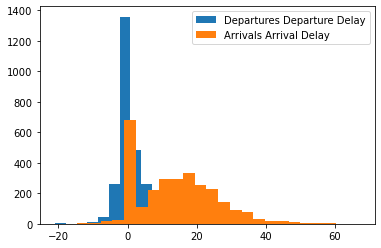

In [38]:
depdel = dataset["departuresDepartureDelay"].to_numpy()
arrdel = dataset["arrivalsArrivalDelay"].to_numpy()

mean_depdel= numpy.mean(depdel)
std_depdel = numpy.std(depdel)
mean_arrdel = numpy.mean(arrdel)
std_arrdel = numpy.std(arrdel)

x_depdel = numpy.linspace(mean_depdel - 3*std_depdel, mean_depdel + 3*std_depdel, 100)
x_arrdel = numpy.linspace(mean_arrdel - 3*std_arrdel, mean_arrdel + 3*std_arrdel, 100)

normal_depdel = norm.pdf(x_depdel, mean_depdel, std_depdel)
normal_arrdel = norm.pdf(x_arrdel, mean_arrdel, std_arrdel)

bin_num = 25
plt.hist(depdel, bins=bin_num, label='Departures Departure Delay')
plt.hist(arrdel, bins=bin_num, label='Arrivals Arrival Delay')
plt.legend()
plt.show()

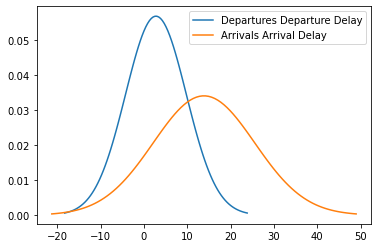

Departures Departure Delay
68.2% confidence interval: -4.243561077992874 until 9.796525134851167
95.4% confidence interval: -11.263604184414895 until 16.81656824127319
99.6% confidence interval: -18.283647290836914 until 23.836611347695207

Arrivals Arrival Delay
68.2% confidence interval: 2.15790683062548 until 25.568043665995482
95.4% confidence interval: -9.547161587059522 until 37.27311208368049
99.6% confidence interval: -21.252230004744526 until 48.97818050136549
7.020043106422021
11.705068417685002


In [44]:
plt.plot(x_depdel, normal_depdel, label='Departures Departure Delay')
plt.plot(x_arrdel, normal_arrdel, label='Arrivals Arrival Delay')
plt.legend()

plt.show()

print("Departures Departure Delay")
print(f"68.2% confidence interval: {mean_depdel - std_depdel} until {mean_depdel + std_depdel}")
print(f"95.4% confidence interval: {mean_depdel - 2*std_depdel} until {mean_depdel + 2*std_depdel}")
print(f"99.6% confidence interval: {mean_depdel - 3*std_depdel} until {mean_depdel + 3*std_depdel}\n")

print("Arrivals Arrival Delay")
print(f"68.2% confidence interval: {mean_arrdel - std_arrdel} until {mean_arrdel + std_arrdel}")
print(f"95.4% confidence interval: {mean_arrdel - 2*std_arrdel} until {mean_arrdel + 2*std_arrdel}")
print(f"99.6% confidence interval: {mean_arrdel - 3*std_arrdel} until {mean_arrdel + 3*std_arrdel}")


print(std_depdel)
print(std_arrdel)

DEFINE AND FIT MODEL

Instead of days we use hours to train the model. We split the data to the first 18 hours of the day and predict the rest 6. Right now we are doing it for only one day. What we need to do instead is to train the model with a lot of days individually and then initiate the model in a certain time that'll be determined by our lookback and and start predicting after that time for a new set of days.

Shape of dataset: (2864, 262)
Shape of train dataset: (2400, 262)
Shape of test dataset: (464, 262)
(2400, 260)
(2400, 1, 260) (2400, 2) (464, 1, 260) (464, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                22480     
                                                                 
 dense (Dense)               (None, 2)                 42        
                                                                 
Total params: 22,522
Trainable params: 22,522
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 5s 19ms/step - loss: 0.1189 - val_loss: 0.0668
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0679 - val_loss: 0.0644
Epoch 3/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0640 - val_loss

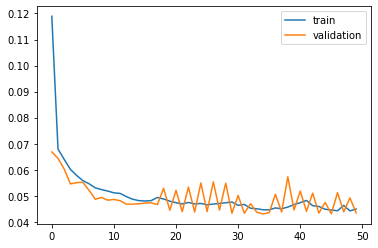

In [5]:
values = reframed.values
# number_of_days_to_train = 20
number_of_hours_to_train = 600
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_hours_to_train * number_of_timeslots_in_one_hour

# split into train, test and validation sets

train = values[:(train_index), :]
#validation = values[(train_index-30):train_index, :]
test = values[train_index:, :]

print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)
#print('Shape of validation dataset:', validation.shape)

# split into input and outputs

train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]
#val_X, val_y = validation[:, :-1], validation[:, -1]
print(train_X.shape)

# reshape input to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], -1, test_X.shape[1]))
#val_X = val_X.reshape((val_X.shape[0], number_of_time_steps, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) #val_X.shape, val_y.shape)


# design network

model = Sequential()

model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')
model.summary()

# fit network

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data = (test_X, test_y), verbose=1, shuffle=False) #validation_data=(val_X, val_y),

# plot history

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5)                 5320      
                                                                 
 dense_1 (Dense)             (None, 2)                 12        
                                                                 
Total params: 5,332
Trainable params: 5,332
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 2s 20ms/step - loss: 0.1027 - val_loss: 0.0553
Epoch 2/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0685 - val_loss: 0.0527
Epoch 3/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0661 - val_loss: 0.0522
Epoch 4/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0641 - val_loss: 0.0514
Epoch 5/50
34/34 [==============================] - 0

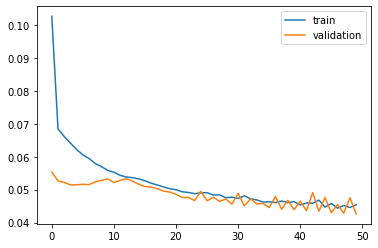

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                10840     
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 10,862
Trainable params: 10,862
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 2s 26ms/step - loss: 0.1115 - val_loss: 0.0554
Epoch 2/50
34/34 [==============================] - 0s 7ms/step - loss: 0.0686 - val_loss: 0.0548
Epoch 3/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0659 - val_loss: 0.0544
Epoch 4/50
34/34 [==============================] - 0s 8ms/step - loss: 0.0628 - val_loss: 0.0549
Epoch 5/50
34/34 [==============================] - 0

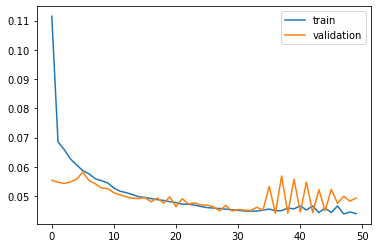

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15)                16560     
                                                                 
 dense_3 (Dense)             (None, 2)                 32        
                                                                 
Total params: 16,592
Trainable params: 16,592
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 2s 26ms/step - loss: 0.1168 - val_loss: 0.0572
Epoch 2/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0674 - val_loss: 0.0592
Epoch 3/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0638 - val_loss: 0.0581
Epoch 4/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0609 - val_loss: 0.0562
Epoch 5/50
34/34 [==============================] 

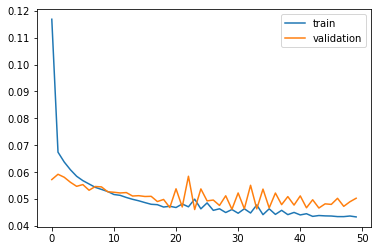

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20)                22480     
                                                                 
 dense_4 (Dense)             (None, 2)                 42        
                                                                 
Total params: 22,522
Trainable params: 22,522
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 2s 23ms/step - loss: 0.1349 - val_loss: 0.0760
Epoch 2/50
34/34 [==============================] - 0s 9ms/step - loss: 0.0724 - val_loss: 0.0600
Epoch 3/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0656 - val_loss: 0.0617
Epoch 4/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0628 - val_loss: 0.0601
Epoch 5/50
34/34 [==============================] -

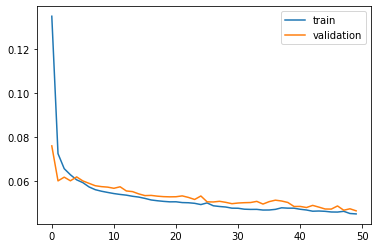

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 25)                28600     
                                                                 
 dense_5 (Dense)             (None, 2)                 52        
                                                                 
Total params: 28,652
Trainable params: 28,652
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 2s 23ms/step - loss: 0.1163 - val_loss: 0.0618
Epoch 2/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0679 - val_loss: 0.0588
Epoch 3/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0624 - val_loss: 0.0620
Epoch 4/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0602 - val_loss: 0.0533
Epoch 5/50
34/34 [==============================] 

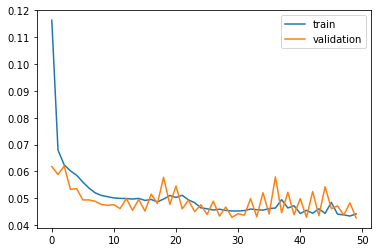

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30)                34920     
                                                                 
 dense_6 (Dense)             (None, 2)                 62        
                                                                 
Total params: 34,982
Trainable params: 34,982
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 35ms/step - loss: 0.1280 - val_loss: 0.0575
Epoch 2/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0688 - val_loss: 0.0615
Epoch 3/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0652 - val_loss: 0.0581
Epoch 4/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0609 - val_loss: 0.0574
Epoch 5/50
34/34 [==============================] 

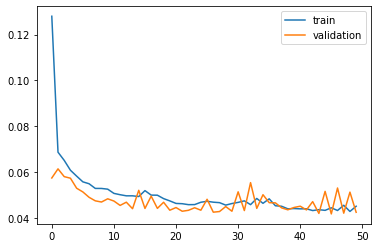

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 35)                41440     
                                                                 
 dense_7 (Dense)             (None, 2)                 72        
                                                                 
Total params: 41,512
Trainable params: 41,512
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 4s 55ms/step - loss: 0.1280 - val_loss: 0.0582
Epoch 2/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0678 - val_loss: 0.0553
Epoch 3/50
34/34 [==============================] - 1s 17ms/step - loss: 0.0626 - val_loss: 0.0553
Epoch 4/50
34/34 [==============================] - 1s 16ms/step - loss: 0.0595 - val_loss: 0.0533
Epoch 5/50
34/34 [==============================] 

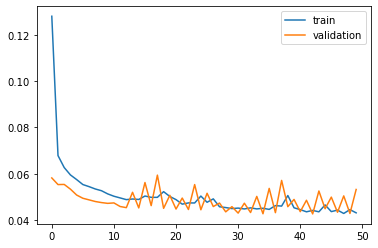

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 40)                48160     
                                                                 
 dense_8 (Dense)             (None, 2)                 82        
                                                                 
Total params: 48,242
Trainable params: 48,242
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 30ms/step - loss: 0.1072 - val_loss: 0.0884
Epoch 2/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0760 - val_loss: 0.0700
Epoch 3/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0656 - val_loss: 0.0671
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0619 - val_loss: 0.0638
Epoch 5/50
34/34 [==============================] 

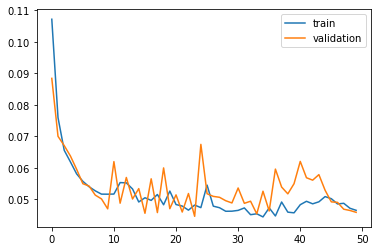

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 45)                55080     
                                                                 
 dense_9 (Dense)             (None, 2)                 92        
                                                                 
Total params: 55,172
Trainable params: 55,172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 32ms/step - loss: 0.1227 - val_loss: 0.0558
Epoch 2/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0746 - val_loss: 0.0568
Epoch 3/50
34/34 [==============================] - 0s 15ms/step - loss: 0.0627 - val_loss: 0.0575
Epoch 4/50
34/34 [==============================] - 1s 15ms/step - loss: 0.0593 - val_loss: 0.0596
Epoch 5/50
34/34 [==============================]

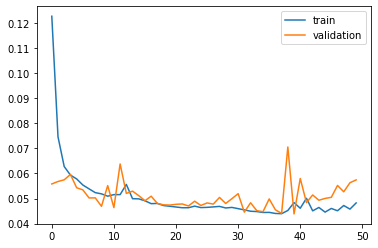

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                62200     
                                                                 
 dense_10 (Dense)            (None, 2)                 102       
                                                                 
Total params: 62,302
Trainable params: 62,302
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 32ms/step - loss: 0.1254 - val_loss: 0.0612
Epoch 2/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0672 - val_loss: 0.0638
Epoch 3/50
34/34 [==============================] - 0s 15ms/step - loss: 0.0624 - val_loss: 0.0645
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0591 - val_loss: 0.0561
Epoch 5/50
34/34 [==============================]

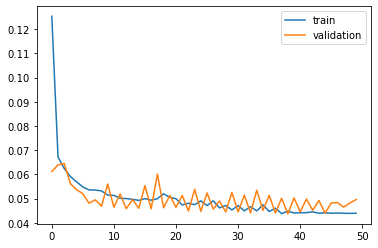

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 55)                69520     
                                                                 
 dense_11 (Dense)            (None, 2)                 112       
                                                                 
Total params: 69,632
Trainable params: 69,632
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 36ms/step - loss: 0.0989 - val_loss: 0.0657
Epoch 2/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0649 - val_loss: 0.0655
Epoch 3/50
34/34 [==============================] - 1s 15ms/step - loss: 0.0593 - val_loss: 0.0509
Epoch 4/50
34/34 [==============================] - 1s 15ms/step - loss: 0.0559 - val_loss: 0.0624
Epoch 5/50
34/34 [==============================]

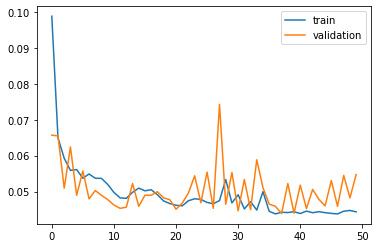

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60)                77040     
                                                                 
 dense_12 (Dense)            (None, 2)                 122       
                                                                 
Total params: 77,162
Trainable params: 77,162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 35ms/step - loss: 0.1192 - val_loss: 0.0776
Epoch 2/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0705 - val_loss: 0.0556
Epoch 3/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0627 - val_loss: 0.0591
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0595 - val_loss: 0.0564
Epoch 5/50
34/34 [==============================]

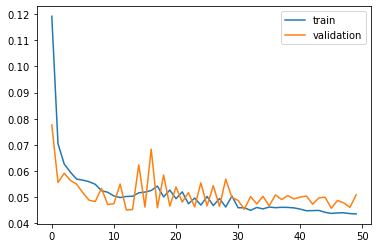

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 65)                84760     
                                                                 
 dense_13 (Dense)            (None, 2)                 132       
                                                                 
Total params: 84,892
Trainable params: 84,892
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 30ms/step - loss: 0.1373 - val_loss: 0.0615
Epoch 2/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0699 - val_loss: 0.0548
Epoch 3/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0621 - val_loss: 0.0568
Epoch 4/50
34/34 [==============================] - 1s 15ms/step - loss: 0.0587 - val_loss: 0.0535
Epoch 5/50
34/34 [==============================]

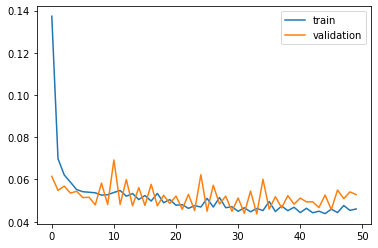

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 70)                92680     
                                                                 
 dense_14 (Dense)            (None, 2)                 142       
                                                                 
Total params: 92,822
Trainable params: 92,822
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 32ms/step - loss: 0.1201 - val_loss: 0.0745
Epoch 2/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0708 - val_loss: 0.0731
Epoch 3/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0568
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0601 - val_loss: 0.0602
Epoch 5/50
34/34 [==============================]

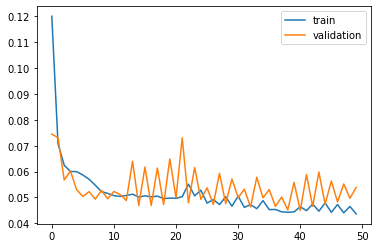

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 75)                100800    
                                                                 
 dense_15 (Dense)            (None, 2)                 152       
                                                                 
Total params: 100,952
Trainable params: 100,952
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 39ms/step - loss: 0.1210 - val_loss: 0.0611
Epoch 2/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0764 - val_loss: 0.0526
Epoch 3/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0616 - val_loss: 0.0550
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0572 - val_loss: 0.0555
Epoch 5/50
34/34 [=============================

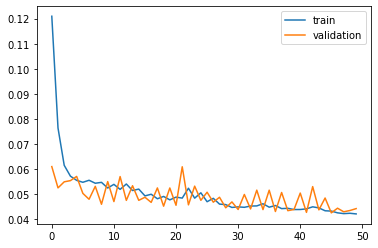

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 80)                109120    
                                                                 
 dense_16 (Dense)            (None, 2)                 162       
                                                                 
Total params: 109,282
Trainable params: 109,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 4s 30ms/step - loss: 0.1411 - val_loss: 0.0650
Epoch 2/50
34/34 [==============================] - 0s 12ms/step - loss: 0.0715 - val_loss: 0.0552
Epoch 3/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0609 - val_loss: 0.0648
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0588 - val_loss: 0.0569
Epoch 5/50
34/34 [=============================

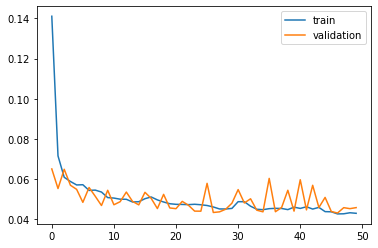

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 85)                117640    
                                                                 
 dense_17 (Dense)            (None, 2)                 172       
                                                                 
Total params: 117,812
Trainable params: 117,812
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
34/34 [==============================] - 3s 31ms/step - loss: 0.1439 - val_loss: 0.0651
Epoch 2/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0649 - val_loss: 0.0676
Epoch 3/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0600 - val_loss: 0.0571
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0557 - val_loss: 0.0539
Epoch 5/50
34/34 [=============================

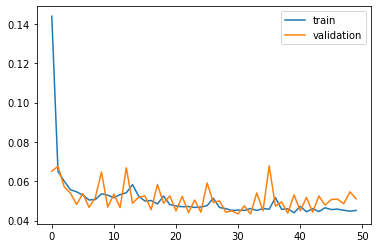

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 90)                126360    
                                                                 
 dense_18 (Dense)            (None, 2)                 182       
                                                                 
Total params: 126,542
Trainable params: 126,542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


In [6]:
mae1_lst = []
mae2_lst = []
neurons_lst = numpy.arange(5, 100, 5)

for neurons in neurons_lst:
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam')
    model.summary()

    # fit network

    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data = (test_X, test_y), verbose=1, shuffle=False) #validation_data=(val_X, val_y),

    # plot history

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    # Generate predictions

    #print(test_X.shape)
    yhat = model.predict(test_X)
    reshaped_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    #print(test_X.shape)

    # See predictions and real values

    # print(yhat)
    # print(test_y)
    # print(yhat.shape)

    # Split and reshape the two desired outputs in separate arrays to prepare for inverse scaling

    yhat1 = yhat[:, 0]
    yhat2 = yhat[:, 1]
    yhat1 = yhat1.reshape(len(yhat), 1)
    yhat2 = yhat2.reshape(len(yhat), 1)
    #print(yhat1.shape, yhat2.shape)

    # Also split the real values of the labels and reshape for inverse scaling

    #print(test_y.shape)
    test_y_1 = test_y[:, 0]
    test_y_2 = test_y[:, 1]
    test_y_1 = test_y_1.reshape(len(test_y), 1)
    test_y_2 = test_y_2.reshape(len(test_y), 1)
    #print(test_y_1.shape, test_y_2.shape)

    # Inverse transform the predictions

    inv_yhat_1 = concatenate((yhat1, yhat2, reshaped_test_X[:, 0:18]), axis=1)
    inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
    inv_yhat_1 = inv_yhat_1[:, :2]

    #print("inv_yhat_1: ", inv_yhat_1)

    # Inverse transform the real values of the labels

    inv_y_1 = concatenate((test_y_1, test_y_2, reshaped_test_X[:, 0:18]), axis=1)
    inv_y_1 = scaler.inverse_transform(inv_y_1)
    inv_y_1 = inv_y_1[:, :2]

    #print("inv_y_1: ", inv_y_1)

    # calculate MAE between predicted and actual labels

    mae1 = mean_absolute_error(inv_y_1[:, 0], inv_yhat_1[:, 0])
    mae1_lst.append(mae1)
    mae2 = mean_absolute_error(inv_y_1[:, 1], inv_yhat_1[:, 1])
    mae2_lst.append(mae2)

    # print('Test MAE1: %.3f' % mae1)
    # print('Test MAE2: %.3f' % mae2)

plt.plot(neurons_lst, mae1_lst, label = 'mae1')
plt.plot(neurons_lst, mae2_lst, label = 'mae2')
plt.legend()
plt.show()
print('minimum mae1 is {} for a number of {} neurons'.format(numpy.min(mae1_lst), neurons_lst[mae1_lst.index(numpy.min(mae1_lst))]))
print('minimum mae2 is {} for a number of {} neurons'. format(numpy.min(mae2_lst), neurons_lst[mae2_lst.index(numpy.min(mae2_lst))]))
        

In [ ]:
mae1_lst = []
mae2_lst = []
lookback_lst = numpy.arange(1, 20, 2)
number_of_future_steps = 2

for lookback in lookback_lst:

    model = Sequential()
    model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam')
    model.summary()

    number_of_past_steps = lookback
    reframed = series_to_supervised(scaled, n_in=number_of_past_steps, n_out=number_of_future_steps)

    # drop columns we don't want to predict

    reframed.drop(columns=reframed.columns[[i for i in range(len(reframed.columns)-20, len(reframed.columns)-2)]], inplace=True)


    values = dataset.values

    values = reframed.values

    values = values.astype('float32')

    # normalize features

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # number_of_days_to_train = 20
    number_of_hours_to_train = 600
    number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
    train_index = number_of_hours_to_train * number_of_timeslots_in_one_hour

    # split into train, test and validation sets

    train = values[:(train_index), :]
    #validation = values[(train_index-30):train_index, :]
    test = values[train_index:, :]

    # print('Shape of dataset:', reframed.shape)
    # print('Shape of train dataset:', train.shape)
    # print('Shape of test dataset:', test.shape)
    #print('Shape of validation dataset:', validation.shape)

    # split into input and outputs

    train_X, train_y = train[:, :-2], train[:, -2:]
    test_X, test_y = test[:, :-2], test[:, -2:]
    #val_X, val_y = validation[:, :-1], validation[:, -1]
    # print(train_X.shape)

    # reshape input to be 3D [samples, timesteps, features]

    train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], -1, test_X.shape[1]))

    # fit network

    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data = (test_X, test_y), verbose=1, shuffle=False) #validation_data=(val_X, val_y),

    # plot history

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    # Generate predictions

    #print(test_X.shape)
    yhat = model.predict(test_X)
    reshaped_test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    #print(test_X.shape)

    # See predictions and real values

    # print(yhat)
    # print(test_y)
    # print(yhat.shape)

    # Split and reshape the two desired outputs in separate arrays to prepare for inverse scaling

    yhat1 = yhat[:, 0]
    yhat2 = yhat[:, 1]
    yhat1 = yhat1.reshape(len(yhat), 1)
    yhat2 = yhat2.reshape(len(yhat), 1)
    #print(yhat1.shape, yhat2.shape)

    # Also split the real values of the labels and reshape for inverse scaling

    #print(test_y.shape)
    test_y_1 = test_y[:, 0]
    test_y_2 = test_y[:, 1]
    test_y_1 = test_y_1.reshape(len(test_y), 1)
    test_y_2 = test_y_2.reshape(len(test_y), 1)
    #print(test_y_1.shape, test_y_2.shape)

    # Inverse transform the predictions

    inv_yhat_1 = concatenate((yhat1, yhat2, reshaped_test_X[:, 0:18]), axis=1)
    inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
    inv_yhat_1 = inv_yhat_1[:, :2]

    #print("inv_yhat_1: ", inv_yhat_1)

    # Inverse transform the real values of the labels

    inv_y_1 = concatenate((test_y_1, test_y_2, reshaped_test_X[:, 0:18]), axis=1)
    inv_y_1 = scaler.inverse_transform(inv_y_1)
    inv_y_1 = inv_y_1[:, :2]

    #print("inv_y_1: ", inv_y_1)

    # calculate MAE between predicted and actual labels

    mae1 = mean_absolute_error(inv_y_1[:, 0], inv_yhat_1[:, 0])
    mae1_lst.append(mae1)
    mae2 = mean_absolute_error(inv_y_1[:, 1], inv_yhat_1[:, 1])
    mae2_lst.append(mae2)

    # print('Test MAE1: %.3f' % mae1)
    # print('Test MAE2: %.3f' % mae2)

plt.plot(lookback_lst, mae1_lst, label = 'mae1')
plt.plot(lookback_lst, mae2_lst, label = 'mae2')
plt.legend()
plt.show()
print('minimum mae1 is {} for a lookback of {}'.format(numpy.min(mae1_lst), lookback_lst[mae1_lst.index(numpy.min(mae1_lst))]))
print('minimum mae2 is {} for a lookback of {}'. format(numpy.min(mae2_lst), lookback_lst[mae2_lst.index(numpy.min(mae2_lst))]))
        

In [ ]:
# Generate predictions

print(test_X.shape)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X.shape)

# See predictions and real values

print(yhat)
print(test_y)
print(yhat.shape)

# Split and reshape the two desired outputs in separate arrays to prepare for inverse scaling

yhat1 = yhat[:, 0]
yhat2 = yhat[:, 1]
yhat1 = yhat1.reshape(len(yhat), 1)
yhat2 = yhat2.reshape(len(yhat), 1)
print(yhat1.shape, yhat2.shape)

# Also split the real values of the labels and reshape for inverse scaling

print(test_y.shape)
test_y_1 = test_y[:, 0]
test_y_2 = test_y[:, 1]
test_y_1 = test_y_1.reshape(len(test_y), 1)
test_y_2 = test_y_2.reshape(len(test_y), 1)
print(test_y_1.shape, test_y_2.shape)

(476, 1, 80)
(476, 80)
[[0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26855895 0.2144103 ]
 [0.26272053 0.35768113]
 [0.26134366 0.3738534 ]
 [0.25925067 0.3598415 ]
 [0.2580266  0.38575354]
 [0.263184   0.408562  ]
 [0.26283938 0.43192717]
 [0.25284612 0.4173585 ]
 [0.25119525 0.4009973 ]
 [0.24824965 0.40284994]
 [0.2251738  0.29016724]
 [0.25153184 0.29838663]
 [0.24465132 0.27852002]
 [0.27263498 0.37013304]
 [0.28332874 0.34432712]
 [0.2960203  0.41261962]
 [0.30287442 0.38116282]
 [0.32230142 0.44823143]
 [0.28396627 0.3549383 ]
 [0.28111026 0.4004943 ]
 [0.25193617 0.33820918]
 [0.27443695 0.36058876]
 [0.27843073 0.34153083]
 [0.28653035 0.3222991 ]
 [0.28167513 0.37142608]
 [0.26752582 0.35602632]
 [0.235293   0.34957507]
 [0.23602372 0.3240609 ]
 [

EVALUATE MODEL AND VISUALIZE PREDICTIONS

Here we inverse the scaling of the labels to get their actual value and calculate the MAE. It'd be useful to create a Normal distribution of the labels so that we know our confidence intervals

In [ ]:
# Inverse transform the predictions

inv_yhat_1 = concatenate((yhat1, yhat2, test_X[:, 0:18]), axis=1)
inv_yhat_1 = scaler.inverse_transform(inv_yhat_1)
inv_yhat_1 = inv_yhat_1[:, :2]

print("inv_yhat_1: ", inv_yhat_1)

# Inverse transform the real values of the labels

inv_y_1 = concatenate((test_y_1, test_y_2, test_X[:, 0:18]), axis=1)
inv_y_1 = scaler.inverse_transform(inv_y_1)
inv_y_1 = inv_y_1[:, :2]

print("inv_y_1: ", inv_y_1)

# calculate MAE between predicted and actual labels

mae1 = mean_absolute_error(inv_y_1[:, 0], inv_yhat_1[:, 0])
mae2 = mean_absolute_error(inv_y_1[:, 1], inv_yhat_1[:, 1])

print('Test MAE1: %.3f' % mae1)
print('Test MAE2: %.3f' % mae2)


inv_yhat_1:  [[ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 5.10262    4.288206 ]
 [ 4.99169    7.1536226]
 [ 4.9655294  7.4770675]
 [ 4.9257627  7.19683  ]
 [ 4.9025054  7.7150707]
 [ 5.0004964  8.17124  ]
 [ 4.993948   8.638543 ]
 [ 4.804076   8.34717  ]
 [ 4.77271    8.019946 ]
 [ 4.7167435  8.056998 ]
 [ 4.278302   5.8033447]
 [ 4.7791047  5.9677324]
 [ 4.648375   5.5704   ]
 [ 5.1800647  7.402661 ]
 [ 5.383246   6.8865423]
 [ 5.624386   8.252392 ]
 [ 5.754614   7.623256 ]
 [ 6.123727   8.964628 ]
 [ 5.395359   7.098766 ]
 [ 5.341095   8.009886 ]
 [ 4.786787   6.7641835]
 [ 5.214302   7.2117753]
 [ 5.290184   6.8306165]
 [ 5.4440765  6.445982 ]
 [ 5.3518276  7.4285216]
 [ 5.0829906  7.1205263]
 [ 4.4705667  6.9915013]
 [ 4.484451   6.481218 ]
 [ 4.47603  

NON SCALED LABELS

This is an attempt to see how the model would wok if we don't scale the outputs. However it's a bit outdated 

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



dataset = generateNNdata("EHAM", timeslotLength=15, catagoricalFlightDuration=False)
dataset = dataset.set_index("timeslot")


dataset.drop(columns=['departuresArrivalDelay','arrivalsArrivalDelay'])
label = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label)

# Get first month of Data
number_of_months = 1
index_slice = number_of_months * 4 * 24 * 31 - 1
dataset = dataset.iloc[0:index_slice]

# summarize first 5 rows
display(dataset)

# Normalize values
values = dataset.values
# display(values)
X, y = values[:,:-1], values[:,-1]
display(X)
display(y)
print(y.shape)
print(type(X), type(y))
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)
# display(scaled)
y = y.reshape((len(y), 1))
scaled = concatenate((X, y), axis=1)
display(scaled)
# frame as supervised learning
number_of_time_steps = 1
number_of_outputs = 1
reframed = series_to_supervised(scaled, n_in=number_of_time_steps, n_out=number_of_outputs)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[i for i in range(20,39)]], axis=1, inplace=True)  # I don't think we need this, but not sure
display(reframed)

,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,arrivalsArrivalDelay,departuresFlightDuration,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,departuresDepartureDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:15:00,1,0,1.00,0.0,0.000000,0.0,183.0,15.0,-1,0.01,0,0,1,0,0,1,0,0,0,12.0
2018-03-01 00:30:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:15:00,0,1,1.00,57.0,9.000000,47.0,0.0,0.0,1,0.01,0,0,1,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31 22:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:15:00,1,3,0.75,192.0,-7.333333,-13.0,673.0,16.0,2,0.04,1,0,1,0,0,0,0,0,1,12.0


array([[1.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [1.  , 3.  , 0.75, ..., 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [1.  , 0.  , 1.  , ..., 0.  , 0.  , 1.  ]])

array([12.,  0.,  0., ..., 12.,  0., -7.])

(2975,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


array([[ 1.  ,  0.  ,  1.  , ...,  0.  ,  0.  , 12.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 1.  ,  3.  ,  0.75, ...,  0.  ,  1.  , 12.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [ 1.  ,  0.  ,  1.  , ...,  0.  ,  1.  , -7.  ]])

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var20(t)
1,1.0,0.0,1.00,0.0,0.000000,0.0,183.0,15.0,-1.0,0.01,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,0.0
2,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.00,57.0,9.000000,47.0,0.0,0.0,1.0,0.01,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2971,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2972,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0
2973,1.0,3.0,0.75,192.0,-7.333333,-13.0,673.0,16.0,2.0,0.04,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0


Shape of dataset: (2974, 21)
Shape of train dataset: (1920, 21)
Shape of test dataset: (1054, 21)
(1920, 1, 20) (1920,) (1054, 1, 20) (1054,)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 50)                14200     
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
27/27 [==============================] - 2s 29ms/step - loss: 4.7249 - val_loss: 4.5461
Epoch 2/75
27/27 [==============================] - 0s 11ms/step - loss: 4.4134 - val_loss: 4.2611
Epoch 3/75
27/27 [==============================] - 0s 11ms/step - loss: 4.2633 - val_loss: 4.1457
Epoch 

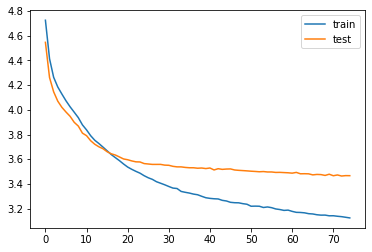

In [ ]:
# split into train and test sets
values = reframed.values
number_of_days_to_train = 20
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_days_to_train * 24 * number_of_timeslots_in_one_hour

train = values[:train_index, :]
test = values[train_index:, :]

print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], -1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], -1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
# make a prediction
yhat = model.predict(test_X)

# calculate MAE
mae = mean_absolute_error(test_y, yhat)
print('Test MAE: %.3f' % mae)

Test MAE: 3.467
